<a href="https://www.kaggle.com/code/anderaraujo/complaints-analysis-of-procon?scriptVersionId=105652888" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Procon project

## Importing some libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotly import graph_objects as go
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

## Getting data

In [2]:

rec_2012 = pd.read_csv('../input/procon/reclamacoes-fundamentadas-sindec-2012.csv')
rec_2013 = pd.read_csv('../input/procon/reclamacoes-fundamentadas-sindec-2013.csv')
rec_2014 = pd.read_csv('../input/procon/reclamacoes-fundamentadas-sindec-2014.csv')
rec_2015 = pd.read_csv('../input/procon/reclamacoes-fundamentadas-sindec-2015.csv')
rec_2016 = pd.read_csv('../input/procon/reclamacoes-fundamentadas-sindec-2016.csv')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (22) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Concatenating all data

In [3]:
rec_all_years = pd.concat([rec_2012, rec_2013, rec_2014, rec_2015, rec_2016], ignore_index= True )

In [4]:
rec_all_years.head()

,AnoCalendario,DataArquivamento,DataAbertura,CodigoRegiao,Regiao,UF,strRazaoSocial,strNomeFantasia,Tipo,NumeroCNPJ,...,CNAEPrincipal,DescCNAEPrincipal,Atendida,CodigoAssunto,DescricaoAssunto,CodigoProblema,DescricaoProblema,SexoConsumidor,FaixaEtariaConsumidor,CEPConsumidor
0,2012,2012-07-13 17:44:45.000,2009-09-17 10:48:42.000,3,Sudeste,ES,IBI PROMOTORA DE VENDAS LTDA.,IBI CARD,1,7.448120e+13,...,7490104.0,ATIVIDADES DE INTERMEDIAÇÃO E AGENCIAMENTO DE ...,N,54,Cartão de Crédito,32.0,Calculo de prestação em atraso,F,mais de 70 anos,29072040
1,2012,2012-07-13 17:37:19.000,2009-09-17 10:02:24.000,3,Sudeste,ES,SAMSUNG ELETRONICA DA AMAZONIA LTDA,SAMSUNG,1,2.802730e+11,...,2640000.0,"FABRICAÇÃO DE APARELHOS DE RECEPÇÃO, REPRODUÇÃ...",N,101,"Telefone ( Convencional, Celular, Interfone, E...",102.0,"Garantia (Abrangência, cobertura, etc.)",M,entre 31 a 40 anos,29115360
2,2012,2012-07-16 09:07:13.000,2009-09-17 11:36:47.000,3,Sudeste,ES,LINNU''S AUTOMOVEIS LTDA.,LINNUS AUTOMOVEIS,1,3.635548e+13,...,4512902.0,COMÉRCIO SOB CONSIGNAÇÃO DE VEÍCULOS AUTOMOTORES,N,129,Carro Nacional Zero ( Montadora ),111.0,Venda enganosa,M,entre 21 a 30 anos,29060110
3,2012,2012-12-10 09:05:09.000,2009-09-21 09:01:49.000,5,Centro-oeste,GO,AMAZON PC INDUSTRIA E COMERCIO DE MICROCOMPUTA...,AMAZON PC,1,1.614079e+12,...,2621300.0,FABRICAÇÃO DE EQUIPAMENTOS DE INFORMÁTICA,S,102,Microcomputador / Produtos de Informática,102.0,"Garantia (Abrangência, cobertura, etc.)",M,entre 21 a 30 anos,75911000
4,2012,2012-07-13 17:51:01.000,2009-09-18 17:32:22.000,3,Sudeste,ES,OFFICINA REVESTIMENTOS LTDA ME,NaN,1,5.444155e+12,...,4744005.0,COMÉRCIO VAREJISTA DE MATERIAIS DE CONSTRUÇÃO ...,N,118,Material de Acabamento de Construção Pronto (P...,116.0,"Contrato/pedido/orçamento (rescisão, descumpri...",M,Nao Informada,29090120


# Feature engineering

In [5]:
# Getting info from data
rec_all_years.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1206072 entries, 0 to 1206071
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   AnoCalendario          1206072 non-null  int64  
 1   DataArquivamento       1206072 non-null  object 
 2   DataAbertura           1206072 non-null  object 
 3   CodigoRegiao           1206072 non-null  int64  
 4   Regiao                 1206072 non-null  object 
 5   UF                     1206072 non-null  object 
 6   strRazaoSocial         1206064 non-null  object 
 7   strNomeFantasia        1006636 non-null  object 
 8   Tipo                   1206072 non-null  int64  
 9   NumeroCNPJ             1153518 non-null  float64
 10  RadicalCNPJ            1152390 non-null  float64
 11  RazaoSocialRFB         1137442 non-null  object 
 12  NomeFantasiaRFB        547639 non-null   object 
 13  CNAEPrincipal          1133380 non-null  float64
 14  DescCNAEPrincipal 

In [6]:
# Getting number of uniques
dict_uniq = {col:[rec_all_years[col].nunique()] for col in rec_all_years.columns}

pd.DataFrame(dict_uniq).T.sort_values(by=0)


,0
Tipo,2
Atendida,2
SexoConsumidor,3
AnoCalendario,5
CodigoRegiao,5
Regiao,5
FaixaEtariaConsumidor,9
UF,26
DescricaoProblema,207
DescricaoAssunto,223


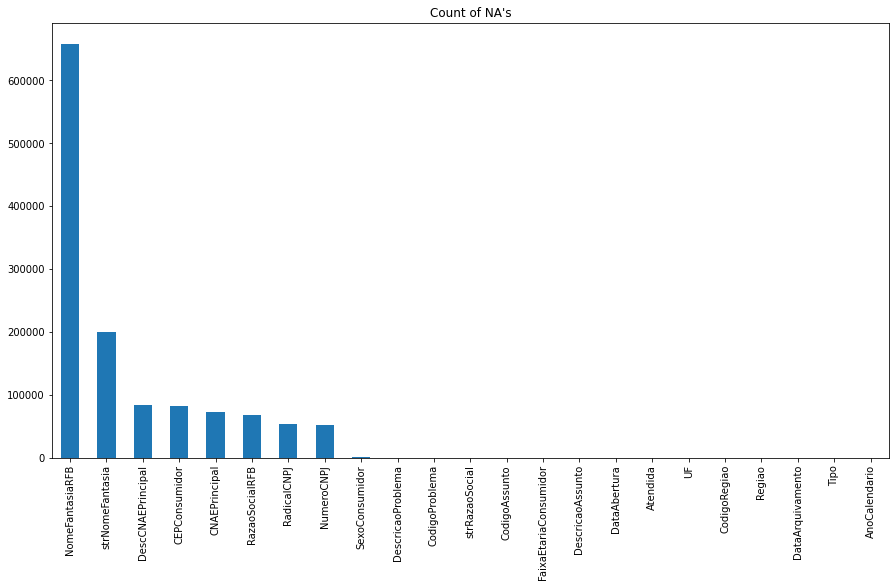

In [7]:
#Getting number of NA values
plt.figure(figsize=(15,8))
rec_all_years.isna().sum().sort_values(ascending = False).plot(kind='bar', title = 'Count of NA\'s' )
plt.show()

In [8]:
# Some information were removed because it would require a lot of work to separate into categories.

rec_all_years = rec_all_years.drop(['NomeFantasiaRFB','strNomeFantasia','DescCNAEPrincipal','CEPConsumidor','CNAEPrincipal','RazaoSocialRFB',
                    'RadicalCNPJ','NumeroCNPJ', 'CodigoRegiao','CodigoAssunto','DescricaoAssunto','strRazaoSocial','CodigoProblema','Tipo'], axis = 1)
rec_all_years.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1206072 entries, 0 to 1206071
Data columns (total 9 columns):
 #   Column                 Non-Null Count    Dtype 
---  ------                 --------------    ----- 
 0   AnoCalendario          1206072 non-null  int64 
 1   DataArquivamento       1206072 non-null  object
 2   DataAbertura           1206072 non-null  object
 3   Regiao                 1206072 non-null  object
 4   UF                     1206072 non-null  object
 5   Atendida               1206072 non-null  object
 6   DescricaoProblema      1206052 non-null  object
 7   SexoConsumidor         1205101 non-null  object
 8   FaixaEtariaConsumidor  1206072 non-null  object
dtypes: int64(1), object(8)
memory usage: 82.8+ MB


In [9]:
# Getting 20% of problems (pareto law)
pd.set_option("display.max_rows", None)
df_pareto_problems = pd.DataFrame(rec_all_years['DescricaoProblema'].value_counts()).reset_index().loc[:56,:]
df_pareto_problems.head()

,index,DescricaoProblema
0,Produto com vício,253866
1,Cobrança indevida/abusiva,177923
2,"Garantia (Abrangência, cobertura, etc.)",127815
3,Cobrança indevida.,91917
4,Não entrega/demora na entrega do produto,59578


In [10]:
print('This case shows that 56 uniques are responsible for {0:.2f} % of problems'.format((df_pareto_problems['DescricaoProblema'].sum()/1206072)*100))

This case shows that 56 uniques are responsible for 94.70 % of problems


In [11]:
#Subseting just data that contains the 56 uniques.
rec_years_pareto = rec_all_years[rec_all_years['DescricaoProblema'].isin(df_pareto_problems['index'])]

In [12]:
rec_years_pareto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1142184 entries, 0 to 1206071
Data columns (total 9 columns):
 #   Column                 Non-Null Count    Dtype 
---  ------                 --------------    ----- 
 0   AnoCalendario          1142184 non-null  int64 
 1   DataArquivamento       1142184 non-null  object
 2   DataAbertura           1142184 non-null  object
 3   Regiao                 1142184 non-null  object
 4   UF                     1142184 non-null  object
 5   Atendida               1142184 non-null  object
 6   DescricaoProblema      1142184 non-null  object
 7   SexoConsumidor         1141214 non-null  object
 8   FaixaEtariaConsumidor  1142184 non-null  object
dtypes: int64(1), object(8)
memory usage: 87.1+ MB


In [13]:
# Checking uniques again
{col:[rec_years_pareto[col].nunique()] for col in rec_years_pareto.columns}

{'AnoCalendario': [5],
 'DataArquivamento': [713548],
 'DataAbertura': [918913],
 'Regiao': [5],
 'UF': [26],
 'Atendida': [2],
 'DescricaoProblema': [57],
 'SexoConsumidor': [3],
 'FaixaEtariaConsumidor': [9]}

In [14]:
rec_years_pareto.head()

,AnoCalendario,DataArquivamento,DataAbertura,Regiao,UF,Atendida,DescricaoProblema,SexoConsumidor,FaixaEtariaConsumidor
0,2012,2012-07-13 17:44:45.000,2009-09-17 10:48:42.000,Sudeste,ES,N,Calculo de prestação em atraso,F,mais de 70 anos
1,2012,2012-07-13 17:37:19.000,2009-09-17 10:02:24.000,Sudeste,ES,N,"Garantia (Abrangência, cobertura, etc.)",M,entre 31 a 40 anos
2,2012,2012-07-16 09:07:13.000,2009-09-17 11:36:47.000,Sudeste,ES,N,Venda enganosa,M,entre 21 a 30 anos
3,2012,2012-12-10 09:05:09.000,2009-09-21 09:01:49.000,Centro-oeste,GO,S,"Garantia (Abrangência, cobertura, etc.)",M,entre 21 a 30 anos
4,2012,2012-07-13 17:51:01.000,2009-09-18 17:32:22.000,Sudeste,ES,N,"Contrato/pedido/orçamento (rescisão, descumpri...",M,Nao Informada


In [15]:
#Transforming data columns to date time
rec_years_pareto['DataAbertura'] = pd.to_datetime(rec_years_pareto['DataAbertura']).dt.date
rec_years_pareto['DataArquivamento'] = pd.to_datetime(rec_years_pareto['DataArquivamento']).dt.date

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
rec_years_pareto.head()

,AnoCalendario,DataArquivamento,DataAbertura,Regiao,UF,Atendida,DescricaoProblema,SexoConsumidor,FaixaEtariaConsumidor
0,2012,2012-07-13,2009-09-17,Sudeste,ES,N,Calculo de prestação em atraso,F,mais de 70 anos
1,2012,2012-07-13,2009-09-17,Sudeste,ES,N,"Garantia (Abrangência, cobertura, etc.)",M,entre 31 a 40 anos
2,2012,2012-07-16,2009-09-17,Sudeste,ES,N,Venda enganosa,M,entre 21 a 30 anos
3,2012,2012-12-10,2009-09-21,Centro-oeste,GO,S,"Garantia (Abrangência, cobertura, etc.)",M,entre 21 a 30 anos
4,2012,2012-07-13,2009-09-18,Sudeste,ES,N,"Contrato/pedido/orçamento (rescisão, descumpri...",M,Nao Informada


In [17]:
# Inserting a column for the period that support takes to help customer.
rec_years_pareto.insert(2,'Period',value = rec_years_pareto['DataArquivamento']-rec_years_pareto['DataAbertura'],
                        allow_duplicates=True)

In [18]:
rec_years_pareto.head()

,AnoCalendario,DataArquivamento,Period,DataAbertura,Regiao,UF,Atendida,DescricaoProblema,SexoConsumidor,FaixaEtariaConsumidor
0,2012,2012-07-13,1030 days,2009-09-17,Sudeste,ES,N,Calculo de prestação em atraso,F,mais de 70 anos
1,2012,2012-07-13,1030 days,2009-09-17,Sudeste,ES,N,"Garantia (Abrangência, cobertura, etc.)",M,entre 31 a 40 anos
2,2012,2012-07-16,1033 days,2009-09-17,Sudeste,ES,N,Venda enganosa,M,entre 21 a 30 anos
3,2012,2012-12-10,1176 days,2009-09-21,Centro-oeste,GO,S,"Garantia (Abrangência, cobertura, etc.)",M,entre 21 a 30 anos
4,2012,2012-07-13,1029 days,2009-09-18,Sudeste,ES,N,"Contrato/pedido/orçamento (rescisão, descumpri...",M,Nao Informada


In [19]:
#Getting only numbers from the period
rec_years_pareto ['Period'] = rec_years_pareto['Period'].dt.days


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [20]:
#Counting values of age
rec_years_pareto['FaixaEtariaConsumidor'].value_counts().sort_values(ascending=False)

entre 31 a 40 anos    262378
entre 41 a 50 anos    221514
entre 21 a 30 anos    194586
entre 51 a 60 anos    175061
entre 61 a 70 anos    112843
Nao Informada          98119
mais de 70 anos        53885
até 20 anos            23164
Nao se aplica            634
Name: FaixaEtariaConsumidor, dtype: int64

In [21]:
# Creating a ordinal level for ages
rec_years_pareto.loc[(rec_years_pareto['FaixaEtariaConsumidor']=='Nao Informada')|(rec_years_pareto['FaixaEtariaConsumidor']=='Nao se aplica'), 'FaixaEtariaConsumidorOrd']= 1
rec_years_pareto.loc[rec_years_pareto['FaixaEtariaConsumidor']=='até 20 anos','FaixaEtariaConsumidorOrd']= 2
rec_years_pareto.loc[rec_years_pareto['FaixaEtariaConsumidor']=='entre 21 a 30 anos','FaixaEtariaConsumidorOrd']= 3
rec_years_pareto.loc[rec_years_pareto['FaixaEtariaConsumidor']=='entre 31 a 40 anos','FaixaEtariaConsumidorOrd']= 4
rec_years_pareto.loc[rec_years_pareto['FaixaEtariaConsumidor']=='entre 41 a 50 anos','FaixaEtariaConsumidorOrd']= 5
rec_years_pareto.loc[rec_years_pareto['FaixaEtariaConsumidor']=='entre 51 a 60 anos','FaixaEtariaConsumidorOrd']= 6
rec_years_pareto.loc[rec_years_pareto['FaixaEtariaConsumidor']=='entre 61 a 70 anos','FaixaEtariaConsumidorOrd']= 7
rec_years_pareto.loc[rec_years_pareto['FaixaEtariaConsumidor']=='mais de 70 anos','FaixaEtariaConsumidorOrd']= 8

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [22]:
rec_years_pareto.head()

,AnoCalendario,DataArquivamento,Period,DataAbertura,Regiao,UF,Atendida,DescricaoProblema,SexoConsumidor,FaixaEtariaConsumidor,FaixaEtariaConsumidorOrd
0,2012,2012-07-13,1030,2009-09-17,Sudeste,ES,N,Calculo de prestação em atraso,F,mais de 70 anos,8.0
1,2012,2012-07-13,1030,2009-09-17,Sudeste,ES,N,"Garantia (Abrangência, cobertura, etc.)",M,entre 31 a 40 anos,4.0
2,2012,2012-07-16,1033,2009-09-17,Sudeste,ES,N,Venda enganosa,M,entre 21 a 30 anos,3.0
3,2012,2012-12-10,1176,2009-09-21,Centro-oeste,GO,S,"Garantia (Abrangência, cobertura, etc.)",M,entre 21 a 30 anos,3.0
4,2012,2012-07-13,1029,2009-09-18,Sudeste,ES,N,"Contrato/pedido/orçamento (rescisão, descumpri...",M,Nao Informada,1.0


In [23]:
# Reducing numbers of problems by grouping them
rec_years_pareto['DescricaoProblema'] =rec_years_pareto['DescricaoProblema'].apply(lambda x: 'garantia' if 'garantia' in str.lower(x) else x)
rec_years_pareto['DescricaoProblema'] =rec_years_pareto['DescricaoProblema'].apply(lambda x: 'venda enganosa' if 'enganosa' in str.lower(x) else x)
rec_years_pareto['DescricaoProblema'] =rec_years_pareto['DescricaoProblema'].apply(lambda x: 'nao cumpre contrato' if 'contrato' in str.lower(x) else x)
rec_years_pareto['DescricaoProblema'] =rec_years_pareto['DescricaoProblema'].apply(lambda x: 'problema com entrega' if 'entrega' in str.lower(x) else x)
rec_years_pareto['DescricaoProblema'] =rec_years_pareto['DescricaoProblema'].apply(lambda x: 'cobranca indevida' if 'indevida' in str.lower(x) else x)
rec_years_pareto['DescricaoProblema'] =rec_years_pareto['DescricaoProblema'].apply(lambda x: 'demora SAC' if 'sac' in str.lower(x) else x)
rec_years_pareto['DescricaoProblema'] =rec_years_pareto['DescricaoProblema'].apply(lambda x: 'erros de calculo' if 'calculo' in str.lower(x) else x)
rec_years_pareto['DescricaoProblema'] =rec_years_pareto['DescricaoProblema'].apply(lambda x: 'servico mal prestado' if 'serviço' in str.lower(x) else x)

rec_years_pareto['DescricaoProblema'].unique()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

array(['erros de calculo', 'garantia', 'venda enganosa',
       'nao cumpre contrato', 'problema com entrega', 'cobranca indevida',
       'Falta de peca de reposição', 'Produto com vício',
       'Demora na montagem/montagem incompleta/incorreta',
       'Crédito Consignado', 'Antecipação de Financiamento',
       'servico mal prestado',
       'Vicio de qualidade (mal executado, inadequado, impróprio)',
       'Produto entregue diferente do pedido', 'Não cumprimento à oferta',
       'demora SAC', 'Desistência de compra (cancelamento de compra)',
       'Documentos: não fornecimento (escolares, recibo, nota, fiscal, vaucher , etc.)',
       'Lançamento Não Reconhecido na Fatura', 'Fila em Banco',
       'Devolução de sinal, valores pagos (negocio não concretizado)',
       'Não pagamento de indenização', 'Produto causou danos materiais',
       'Produto entregue incompleto', 'Negativa de Cobertura',
       'Discordância quanto as avarias',
       'Tarifas Bancárias – Cobrança não aut

In [24]:
# grouping different problems about broken products
rec_years_pareto.loc[rec_years_pareto['DescricaoProblema'].isin(['Discordância quanto as avarias',
                                                                 'Defeito/Risco à saúde e segurança',
                                                                'Vicio de qualidade (mal executado, inadequado, impróprio)',
                                                                 'Produto entregue incompleto',
                                                                 'Produto entregue diferente do pedido',
                                                                 'Demora na montagem/montagem incompleta/incorreta',
                                                                 'Falta de peca de reposição',
                                                                 'Produto com vício',
                                                                 'Produto causou danos materiais'
                                                                 ]),'DescricaoProblema'] = 'produto avariado'

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [25]:
# grouping different problems about sales
rec_years_pareto.loc[rec_years_pareto['DescricaoProblema'].isin([
    'Crédito Consignado',
     'Antecipação de Financiamento',
    'Tarifas Bancárias – Cobrança não autorizada.',
    'Lançamento Não Reconhecido na Fatura',
    'Fila em Banco', 
]), 'DescricaoProblema']='reclamacoes sobre bancos'

rec_years_pareto.loc[rec_years_pareto['DescricaoProblema'].isin(['Não cumprimento à oferta',
                                                                ]),'DescricaoProblema']='venda enganosa'


In [26]:
rec_years_pareto['DescricaoProblema'].nunique()

15

In [27]:
rec_years_pareto['DescricaoProblema'].value_counts()

produto avariado                                                                  331406
cobranca indevida                                                                 285407
nao cumpre contrato                                                               144713
garantia                                                                          134689
problema com entrega                                                               65550
reclamacoes sobre bancos                                                           35181
demora SAC                                                                         34920
servico mal prestado                                                               34146
venda enganosa                                                                     33278
erros de calculo                                                                   16693
Desistência de compra (cancelamento de compra)                                     14330
Não pagamento de inde

In [28]:
rec_years_pareto.head()

,AnoCalendario,DataArquivamento,Period,DataAbertura,Regiao,UF,Atendida,DescricaoProblema,SexoConsumidor,FaixaEtariaConsumidor,FaixaEtariaConsumidorOrd
0,2012,2012-07-13,1030,2009-09-17,Sudeste,ES,N,erros de calculo,F,mais de 70 anos,8.0
1,2012,2012-07-13,1030,2009-09-17,Sudeste,ES,N,garantia,M,entre 31 a 40 anos,4.0
2,2012,2012-07-16,1033,2009-09-17,Sudeste,ES,N,venda enganosa,M,entre 21 a 30 anos,3.0
3,2012,2012-12-10,1176,2009-09-21,Centro-oeste,GO,S,garantia,M,entre 21 a 30 anos,3.0
4,2012,2012-07-13,1029,2009-09-18,Sudeste,ES,N,nao cumpre contrato,M,Nao Informada,1.0


In [29]:
#Filling NA for Customer sex with mode
rec_years_pareto['SexoConsumidor'].fillna(rec_years_pareto['SexoConsumidor'].mode()[0], inplace = True)

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [30]:
rec_years_pareto.isnull().any()

AnoCalendario               False
DataArquivamento            False
Period                      False
DataAbertura                False
Regiao                      False
UF                          False
Atendida                    False
DescricaoProblema           False
SexoConsumidor              False
FaixaEtariaConsumidor       False
FaixaEtariaConsumidorOrd    False
dtype: bool

In [31]:
# Translating regions of Brazil
rec_years_pareto.loc[rec_years_pareto['Regiao']=='Sudeste','Regiao']= 'South west'
rec_years_pareto.loc[rec_years_pareto['Regiao']=='Centro-oeste','Regiao']= 'Mid west'
rec_years_pareto.loc[rec_years_pareto['Regiao']=='Nordeste','Regiao']= 'North west'
rec_years_pareto.loc[rec_years_pareto['Regiao']=='Norte','Regiao']= 'North'
rec_years_pareto.loc[rec_years_pareto['Regiao']=='Sul','Regiao']= 'South'

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [32]:
#Translating age of customers
rec_years_pareto.loc[rec_years_pareto['FaixaEtariaConsumidor']=='mais de 70 anos','FaixaEtariaConsumidor']='more than 70'
rec_years_pareto.loc[rec_years_pareto['FaixaEtariaConsumidor']=='entre 41 a 50 anos','FaixaEtariaConsumidor']='41 to 50'
rec_years_pareto.loc[rec_years_pareto['FaixaEtariaConsumidor']=='entre 31 a 40 anos','FaixaEtariaConsumidor']='31 to 40'
rec_years_pareto.loc[rec_years_pareto['FaixaEtariaConsumidor']=='entre 21 a 30 anos','FaixaEtariaConsumidor']='21 to 30'
rec_years_pareto.loc[rec_years_pareto['FaixaEtariaConsumidor']=='entre 51 a 60 anos','FaixaEtariaConsumidor']='51 to 60'
rec_years_pareto.loc[rec_years_pareto['FaixaEtariaConsumidor']=='entre 61 a 70 anos','FaixaEtariaConsumidor']='61 to 70'
rec_years_pareto.loc[rec_years_pareto['FaixaEtariaConsumidor']=='Nao Informada','FaixaEtariaConsumidor']='Not informed'
rec_years_pareto.loc[rec_years_pareto['FaixaEtariaConsumidor']=='Nao se aplica','FaixaEtariaConsumidor']='Not informed'
rec_years_pareto.loc[rec_years_pareto['FaixaEtariaConsumidor']=='até 20 anos','FaixaEtariaConsumidor']='up to 20'


In [33]:
rec_years_pareto.FaixaEtariaConsumidor.unique()

array(['more than 70', '31 to 40', '21 to 30', 'Not informed', '41 to 50',
       '51 to 60', '61 to 70', 'up to 20'], dtype=object)

In [34]:
#Translating problems to english
rec_years_pareto.loc[rec_years_pareto['DescricaoProblema']=='produto avariado','DescricaoProblema']='damaged product'
rec_years_pareto.loc[rec_years_pareto['DescricaoProblema']=='cobranca indevida','DescricaoProblema']='undue charge'
rec_years_pareto.loc[rec_years_pareto['DescricaoProblema']=='nao cumpre contrato','DescricaoProblema']='contract compliance'
rec_years_pareto.loc[rec_years_pareto['DescricaoProblema']=='garantia','DescricaoProblema']='guarantee'
rec_years_pareto.loc[rec_years_pareto['DescricaoProblema']=='reclamacoes sobre bancos','DescricaoProblema']='complaints about banks'
rec_years_pareto.loc[rec_years_pareto['DescricaoProblema']=='demora SAC','DescricaoProblema']='support delay'
rec_years_pareto.loc[rec_years_pareto['DescricaoProblema']=='servico mal prestado','DescricaoProblema']='bad service'
rec_years_pareto.loc[rec_years_pareto['DescricaoProblema']=='venda enganosa','DescricaoProblema']='misleading sales'
rec_years_pareto.loc[rec_years_pareto['DescricaoProblema']=='erros de calculo','DescricaoProblema']='calc mistakes'
rec_years_pareto.loc[rec_years_pareto['DescricaoProblema']=='Desistência de compra (cancelamento de compra)','DescricaoProblema']='canceled sale'
rec_years_pareto.loc[rec_years_pareto['DescricaoProblema']=='Não pagamento de indenização','DescricaoProblema']='unpaid compensation'
rec_years_pareto.loc[rec_years_pareto['DescricaoProblema']=='Documentos: não fornecimento (escolares, recibo, nota, fiscal, vaucher , etc.)','DescricaoProblema']='missing documents'
rec_years_pareto.loc[rec_years_pareto['DescricaoProblema']=='Devolução de sinal, valores pagos (negocio não concretizado)','DescricaoProblema']='canceled sale'
rec_years_pareto.loc[rec_years_pareto['DescricaoProblema']=='Negativa de Cobertura','DescricaoProblema']='health plan coverage not met'
rec_years_pareto.loc[rec_years_pareto['DescricaoProblema']=='problema com entrega','DescricaoProblema']='delivery complaints'

# Exploratory Data analysis

## What year Brazil had best responses for customer complains ?

In [35]:
rec_pivot = rec_years_pareto.pivot_table('Period', index='AnoCalendario', columns='Atendida', aggfunc='count')
rec_pivot

Atendida,N,S
AnoCalendario,,
2012,80023,121449
2013,95219,160167
2014,89135,165758
2015,83759,158615
2016,75314,112745


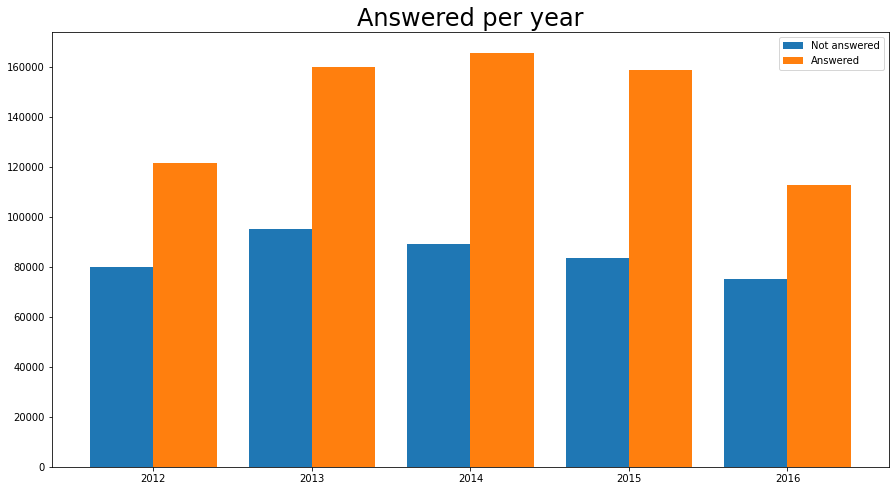

In [36]:
width = 0.4
plt.figure(figsize = (15,8))
plt.bar(x= rec_pivot.loc[:,('N')].index-0.2, height = rec_pivot.loc[:,('N')], width=0.4 )
plt.bar(x= rec_pivot.loc[:,('S')].index+0.2, height = rec_pivot.loc[:,('S')], width=0.4)
plt.legend(['Not answered','Answered'])
plt.title('Answered per year', fontdict= {'fontsize': 24})
plt.show()

## How are the answers per region?

In [37]:
rec_pivot = rec_years_pareto.pivot_table('Period', index='Regiao', columns='Atendida', aggfunc='count')
rec_pivot

Atendida,N,S
Regiao,,
Mid west,54488,122669
North,26462,54072
North west,131776,253720
South,33468,64691
South west,177256,223582


In [38]:
rec_pivot.loc[:,('N')]

Regiao
Mid west       54488
North          26462
North west    131776
South          33468
South west    177256
Name: N, dtype: int64

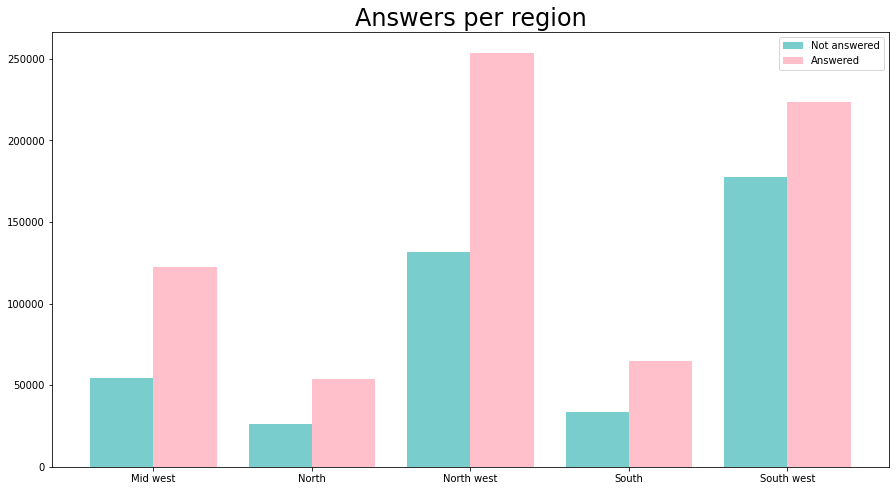

In [39]:
width = 0.4
plt.figure(figsize = (15,8))
labels = rec_pivot.loc[:,('N')].index
x = np.arange(len(labels))

plt.bar(x= x - width/2, height = rec_pivot.loc[:,('N')], width=0.4, color = '#79CDCD' )
plt.bar(x= x + width/2, height = rec_pivot.loc[:,('S')], width=0.4, color = 'pink')
plt.legend(['Not answered','Answered'])
plt.title('Answers per region', fontdict= {'fontsize': 24})
plt.xticks(x, labels)
plt.show()

## Is sex an influencer factor for answers?

In [40]:
answer_per_sex = rec_years_pareto.pivot_table(values = 'AnoCalendario',index=['SexoConsumidor'], columns= 'Atendida', aggfunc= 'count')
answer_per_sex

Atendida,N,S
SexoConsumidor,,
F,217439,388927
M,201765,328591
N,4246,1216


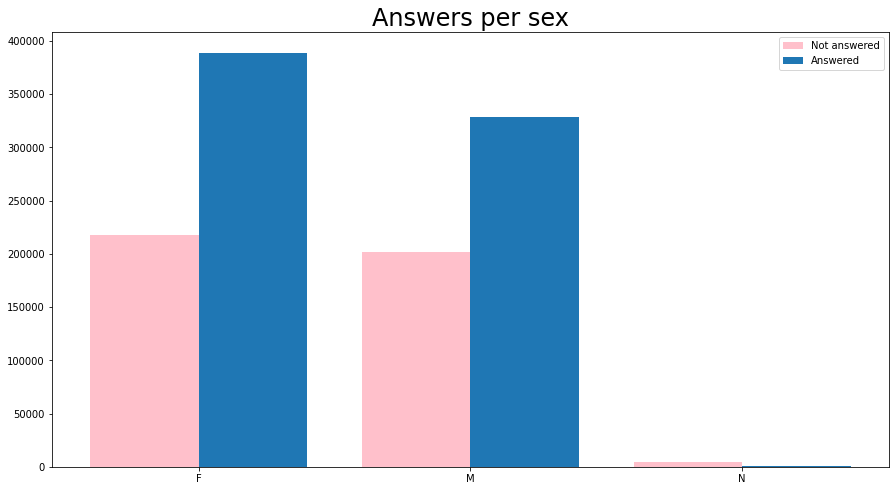

In [41]:
plt.figure(figsize=(15, 8))
width = 0.4
labels = answer_per_sex.loc[:,].index
x = np.arange(len(labels))
plt.bar(x= x - width/2, height = answer_per_sex.loc[:,'N'], width= width, color = 'pink')
plt.bar(x= x + width/2, height = answer_per_sex.loc[:,'S'], width= width)
plt.legend(['Not answered','Answered'])
plt.title('Answers per sex', fontdict= {'fontsize': 24})
plt.xticks(x, labels)
plt.show()

## What kind of problem customers complain the most?

In [42]:
answer_per_problems = rec_years_pareto.pivot_table(values= 'AnoCalendario', index= 'DescricaoProblema', columns = 'Atendida', aggfunc= 'count')
answer_per_problems = answer_per_problems.sort_values(['N','S'])

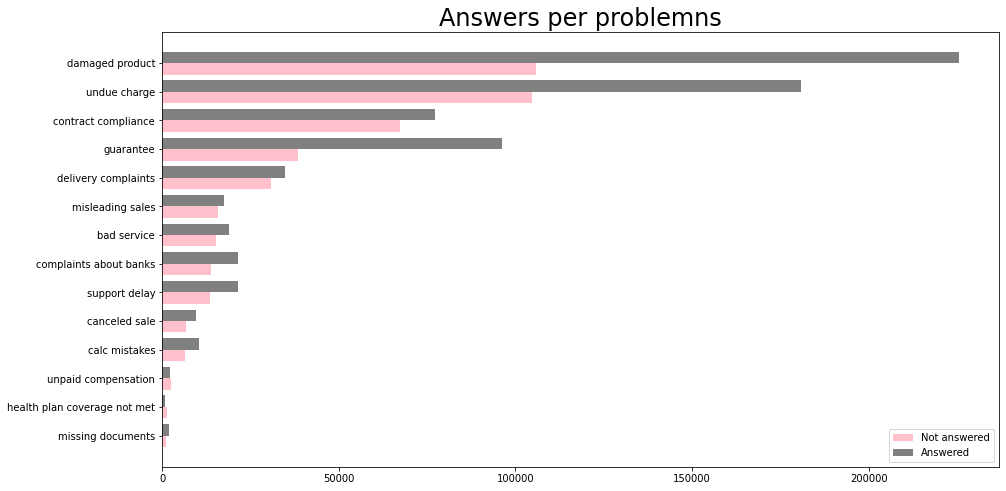

In [43]:
plt.figure(figsize=(15, 8))
h = 0.4
labels = answer_per_problems.loc[:,].index
y = np.arange(len(labels))
plt.barh(y= y - h/2, width = answer_per_problems.loc[:,'N'], height=h, color = 'pink')
plt.barh(y= y + h/2, width = answer_per_problems.loc[:,'S'], height=h, color = 'grey')
plt.legend(['Not answered','Answered'])
plt.title('Answers per problemns', fontdict= {'fontsize': 24})
plt.yticks(y, labels)
plt.show()

## How customer age influences the responses?

In [44]:
answer_per_age = rec_years_pareto.pivot_table(values='AnoCalendario', index ='FaixaEtariaConsumidor', columns = 'Atendida', aggfunc= 'count')
answer_per_age = answer_per_age.sort_values(by = ['N','S'])
answer_per_age

Atendida,N,S
FaixaEtariaConsumidor,,
up to 20,8149,15015
more than 70,18945,34940
61 to 70,40063,72780
Not informed,41822,56931
51 to 60,63414,111647
21 to 30,72912,121674
41 to 50,81084,140430
31 to 40,97061,165317


In [45]:
rec_years_pareto.columns

Index(['AnoCalendario', 'DataArquivamento', 'Period', 'DataAbertura', 'Regiao',
       'UF', 'Atendida', 'DescricaoProblema', 'SexoConsumidor',
       'FaixaEtariaConsumidor', 'FaixaEtariaConsumidorOrd'],
      dtype='object')

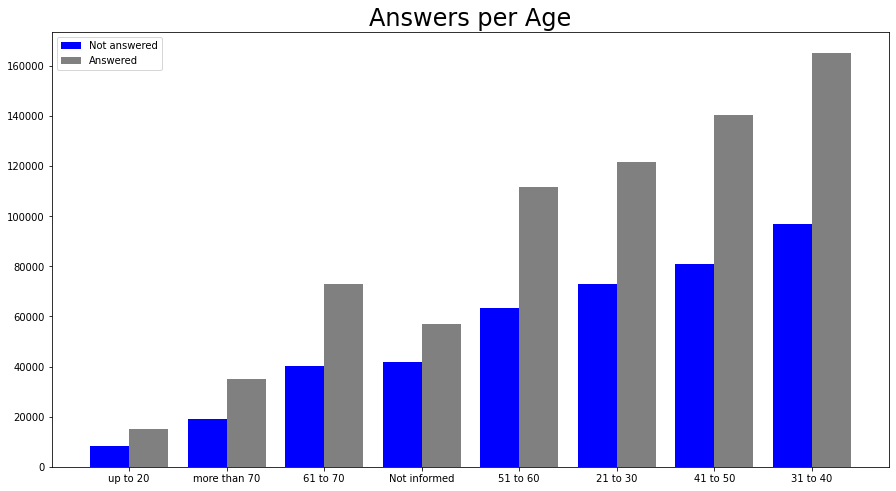

In [46]:
labels = answer_per_age.loc[:,].index
x = np.arange(len(labels))
width = 0.4
plt.figure(figsize=(15,8))
plt.bar(x = x - width/2, height = answer_per_age.loc[:, 'N'], width = width, color = 'blue')
plt.bar(x = x + width/2, height = answer_per_age.loc[:, 'S'], width = width, color = 'grey')
plt.legend(['Not answered','Answered'],)
plt.title('Answers per Age', fontdict= {'fontsize': 24})
plt.xticks(x, labels)
plt.show()

## What state leads the number of complains?

In [47]:
answers_per_uf = rec_years_pareto.pivot_table(values = 'AnoCalendario',index = 'UF', columns= 'Atendida', aggfunc= 'count')
answers_per_uf = answers_per_uf.sort_values(by = ['N','S'])
answers_per_uf.head()

Atendida,N,S
UF,,
RS,810,681
AP,822,1416
SE,1506,1960
AM,2115,6941
AC,2683,4099


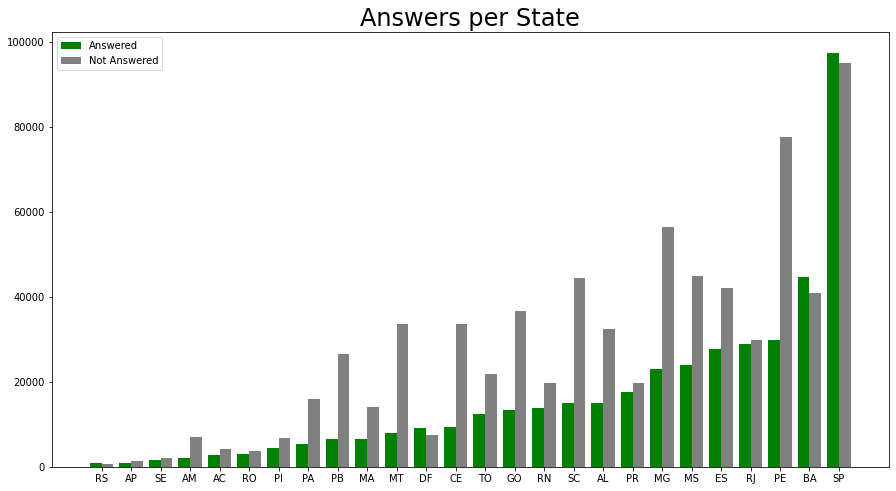

In [48]:
labels = answers_per_uf.loc[:,].index
x = np.arange(len(labels))
width = 0.4
plt.figure(figsize = (15,8))
plt.bar(x = x - width/2, height = answers_per_uf.loc[:, 'N'] , width = width, color = 'green')
plt.bar(x = x + width/2, height = answers_per_uf.loc[:, 'S'] , width = width, color = 'grey')
plt.xticks(x, labels)
plt.legend(['Answered', 'Not Answered'])
plt.title('Answers per State', fontdict = {'fontsize':24} )
plt.show()

In [49]:
# We are gonna exclude the columns Ano, DataArquivamento, Period as well. Period is correlated to Yes or
#not, because when it takes more time it normally gets 'N' as result.
{col: rec_years_pareto[col].nunique() for col in rec_years_pareto.columns}

{'AnoCalendario': 5,
 'DataArquivamento': 1566,
 'Period': 3143,
 'DataAbertura': 3166,
 'Regiao': 5,
 'UF': 26,
 'Atendida': 2,
 'DescricaoProblema': 14,
 'SexoConsumidor': 3,
 'FaixaEtariaConsumidor': 8,
 'FaixaEtariaConsumidorOrd': 8}

In [50]:
rec_years_final = rec_years_pareto.drop(columns=['DataArquivamento','DataAbertura','FaixaEtariaConsumidor'])

# Encoding data and spliting for models

In [51]:
scaler = MinMaxScaler()
age = scaler.fit_transform(rec_years_final[['FaixaEtariaConsumidorOrd']])
period = scaler.fit_transform(rec_years_final[['Period']])
rec_years_final.drop(['FaixaEtariaConsumidorOrd','Period'], axis = 1, inplace = True)
rec_years_final.loc[rec_years_final['Atendida']=='N', 'Atendida'] = 0
rec_years_final.loc[rec_years_final['Atendida']=='S', 'Atendida'] = 1
rec_years_final.head()

,AnoCalendario,Regiao,UF,Atendida,DescricaoProblema,SexoConsumidor
0,2012,South west,ES,0,calc mistakes,F
1,2012,South west,ES,0,guarantee,M
2,2012,South west,ES,0,misleading sales,M
3,2012,Mid west,GO,1,guarantee,M
4,2012,South west,ES,0,contract compliance,M


In [52]:
y = rec_years_final['Atendida'].astype('int64')
x = rec_years_final.drop('Atendida', axis = 1)

In [53]:
oe = OneHotEncoder(sparse = False)
x = oe.fit_transform(x)

In [54]:
transformed_df = pd.DataFrame(x, columns = oe.get_feature_names())

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [55]:
transformed_df.head()

,x0_2012,x0_2013,x0_2014,x0_2015,x0_2016,x1_Mid west,x1_North,x1_North west,x1_South,x1_South west,...,x3_guarantee,x3_health plan coverage not met,x3_misleading sales,x3_missing documents,x3_support delay,x3_undue charge,x3_unpaid compensation,x4_F,x4_M,x4_N
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [56]:
transformed_df['Age'] = age
transformed_df['Period'] = period
transformed_df.head()

,x0_2012,x0_2013,x0_2014,x0_2015,x0_2016,x1_Mid west,x1_North,x1_North west,x1_South,x1_South west,...,x3_misleading sales,x3_missing documents,x3_support delay,x3_undue charge,x3_unpaid compensation,x4_F,x4_M,x4_N,Age,Period
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.000000,0.262209
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.428571,0.262209
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.285714,0.262960
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.285714,0.298773
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.261958


In [57]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size= 0.3, random_state= 0)

# Defining models

## Testing XGBClassifier model

In [58]:
model = XGBClassifier(n_estimators = 100, learning_rate = 0.1, n_jobs = 4, use_label_encoder=False)

In [59]:
model.fit(x_train, y_train, early_stopping_rounds = 5, eval_set = [(x_test, y_test)], verbose = False)

[11:43:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [60]:
y_pred = model.predict(x_test)

In [61]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.31      0.40    126785
           1       0.68      0.88      0.77    215871

    accuracy                           0.67    342656
   macro avg       0.64      0.59      0.59    342656
weighted avg       0.65      0.67      0.63    342656



## Testing Logistic  regression model

In [62]:
model_lr = LogisticRegression()

In [63]:
model_lr.fit(x_train, y_train)
y_pred_lr = model_lr.predict(x_test)

In [64]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.56      0.30      0.39    126785
           1       0.68      0.86      0.76    215871

    accuracy                           0.65    342656
   macro avg       0.62      0.58      0.57    342656
weighted avg       0.63      0.65      0.62    342656



## Getting feature importance from XGB Classifier

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


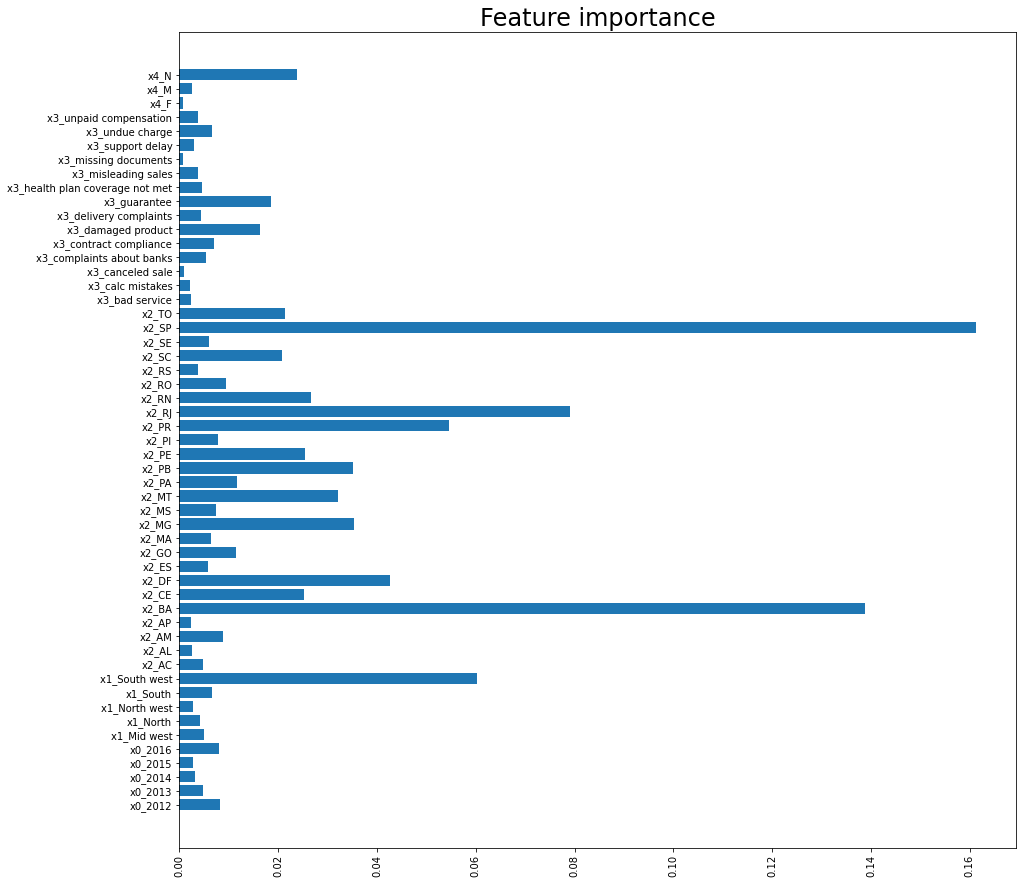

In [65]:
fig, ax = plt.subplots(figsize = (15,15))
ax.barh(width = model.feature_importances_, y = oe.get_feature_names())
plt.xticks(rotation = 90)
plt.title("Feature importance", fontdict={'fontsize': 24})
plt.show()


Xgb Classifier model got best result than Logistic regression model. Both models did not get good results. 